In [4]:
%load_ext autoreload
%autoreload 2

import os
import json
import main
import random
import numpy as np
import matplotlib.pyplot as plt
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser
from tqdm import tqdm
from dataraw_sampling import decode_key_idx, encode_key_idx, decode_query_idx_to_card_properties, decode_key_idx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def find_eulcidean(v, Wv):
    # (b, ), similarity = negative distance
    return - np.sum((v.reshape(1, -1) - Wv)**2, axis=-1)**(1/2)

def find_cos(v, Wv):
    dot_products = np.dot(Wv, v) # shape v,1
    l2norm_products = np.multiply(np.linalg.norm(Wv, axis=1),np.linalg.norm(v)) #shape v,1
    cos_sim = np.divide(dot_products,l2norm_products)
    return cos_sim

def find_dotproduct(v, Wv):
    # (b,)
    print('hit')
    return np.dot(Wv, v)

def find_nn(v, Wv, similarity_fn, k=None):
    """Find nearest neighbors of a given word, by cosine similarity.
    
    Returns two parallel lists: indices of nearest neighbors, and 
    their cosine similarities. Both lists are in descending order, 
    and inclusive: so nns[0] should be the index of the input word, 
    nns[1] should be the index of the first nearest neighbor, and so on.
    
    You may find the following numpy functions useful:
      np.linalg.norm : take the l2-norm of a vector or matrix
      np.dot : dot product or matrix multiplication
      np.argsort : get indices sorted by element value,
        so np.argsort(numbers)[-5:] will return the top five elements
    
    Args:
      v: (d-dimensional vector) word vector of interest
      Wv: (V x d matrix) word embeddings
      k: (int) number of neighbors to return
    
    Returns (nns, ds), where:
      nns: (k-dimensional vector of int), row indices of nearest neighbors, 
        which may include the given word.
      similarities: (k-dimensional vector of float), cosine similarity of each 
        neighbor in nns.
    """
    if k is None:
        k = Wv.shape[0]
    sim = similarity_fn(v, Wv)
    nns = np.argsort(sim)[-k:][::-1]
    similarities = np.take(sim, nns)
    return nns, similarities

def analogy(vA, vB, vC, Wv, k, similarity_fn):
    """Compute a linear analogy in vector space, as described in the async.
    Find the vector(s) that best answer "A is to B as C is to ___", returning 
    the top k candidates by cosine similarity.
    
    Args:
      vA: (d-dimensional vector) vector for word A
      vB: (d-dimensional vector) vector for word B
      vC: (d-dimensional vector) vector for word C
      Wv: (V x d matrix) word embeddings
      k: (int) number of neighbors to return
    Returns (nns, ds), where:
      nns: (k-dimensional vector of int), row indices of the top candidate 
        words.
      similarities: (k-dimensional vector of float), cosine similarity of each 
        of the top candidate words.
    """
    A_to_B = vB - vA
    vD = vC + A_to_B
    return find_nn(vD, Wv, similarity_fn, k)
    
    
def construct_filter(count_table, hparams, num_attr_shared_in_query, num_attr_hit_by_key=None):
    '''compute filters'''
    keep_queries = []
    keep_querykeys = np.zeros(count_table.shape)
    for i in range((hparams['query_support_size'])):
        card1, card2 = queryidx_to_querypair(hparams['num_attributes'], hparams['num_attr_vals'], i)
        if np.sum(card1 == card2) == num_attr_shared_in_query:
            keep_queries.append(True)
            for j in range(hparams['key_support_size']):
                num_matches = check_q1q2k_match(hparams['num_attributes'], hparams['num_attr_vals'], card1, card2, j)
                if num_matches == num_attr_hit_by_key:
                    keep_querykeys[j,i] = 1.0
        else:
            keep_queries.append(False)

    return keep_queries, keep_querykeys

In [5]:
# arguments
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
args = parser.parse_args('')

args.data_path = '../Raw_Datasets/SET/4Attr-3Vals-2NestDepth-2CardsPerQ-Full-6561Train-6561Val.json'
args.config_path = 'config.json'
args.mode = 'train'
args.generate_full_matrix = True

In [6]:
game_data = main.load_data(args.data_path)
main.validate_data(game_data)
hparams = main.load_hparams(args, game_data)

---------data----------
num_attributes : 4
num_attr_vals : 3
num_cards_per_query : 2
nest_depth_int : 2
key_support_size : 81
query_support_size : 6561
hold_out : False
train_datapoints length : 6561
val_datapoints length : 6561
train_tokens length : 6561
val_tokens length : 6561
sparsity_estimate : 0.012345679012345678
vocab_size : 19
( : 12
) : 13
NULL : 14
SEP : 15
SOS : 16
EOS : 17
PAD : 18
-----------------------
----------hparams----------
seed : 42
batch_size : 512
max_epochs : 5000
d_model : 48
embed_dropout : 0.0
model : contrastive
embedding_by_property : False
encoder : lookup
decoder : lookup
d_ff : 1024
num_heads : 1
N_enc : 2
N_dec : 2
attn_wt_tying_scheme : untie_QKVO_zero_O
attn_wt_dropout : 0.0
heads_dropout : 0.0
pff_dropout : 0.0
representation_pos : 0
dotproduct_bottleneck : True
normalize_dotproduct : True
contrastive_use_infoNCE : True
loss_temperature_const : 1.0
loss_smoothing_const : 0.1
nonlinear_classifier_scale_down_factor : [2, 1]
adam_lr : 0.001
adam_beta1

In [7]:
gt = main.gen_full_matrix(hparams)
xy = gt['xy']
xy_div_xyind = gt['xy_div_xyind']
count_table = gt['count_table']

Generating Full Matrix
{'num_keys': 81, 'num_queries': 6561, 'tot_size': 531441, 'shape': (81, 6561), 'size': 531441, 'sparsity': 0.012345679012345678, 'xy_rank': 81, 'xy_div_xyind_rank': 81}


In [8]:
np.linalg.matrix_rank(xy)

81

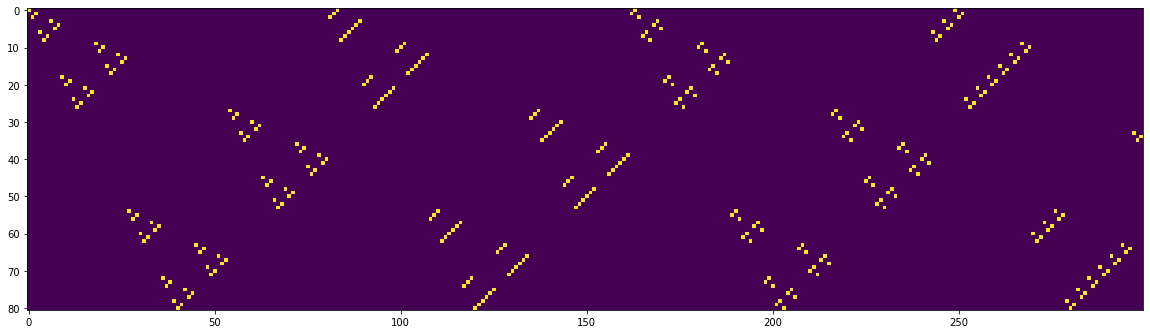

In [10]:
plt.figure(figsize=(20, 50))
plt.imshow(xy_div_xyind[:, :300])

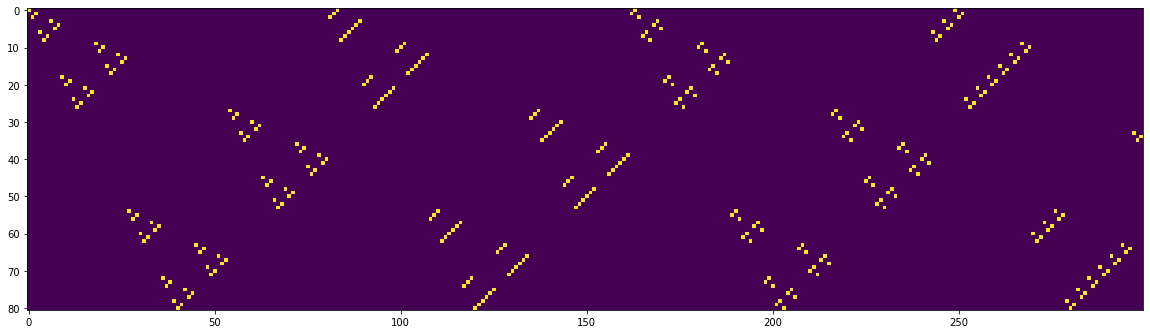

In [11]:
plt.figure(figsize=(20, 50))
plt.imshow(xy_div_xyind[:, :300])

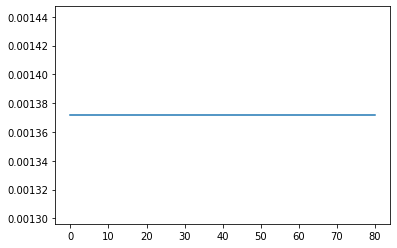

In [12]:
u,s,vh = np.linalg.svd(xy, full_matrices=False)
plt.plot(s)

In [13]:
s

array([0.00137174, 0.00137174, 0.00137174, 0.00137174, 0.00137174,
       0.00137174, 0.00137174, 0.00137174, 0.00137174, 0.00137174,
       0.00137174, 0.00137174, 0.00137174, 0.00137174, 0.00137174,
       0.00137174, 0.00137174, 0.00137174, 0.00137174, 0.00137174,
       0.00137174, 0.00137174, 0.00137174, 0.00137174, 0.00137174,
       0.00137174, 0.00137174, 0.00137174, 0.00137174, 0.00137174,
       0.00137174, 0.00137174, 0.00137174, 0.00137174, 0.00137174,
       0.00137174, 0.00137174, 0.00137174, 0.00137174, 0.00137174,
       0.00137174, 0.00137174, 0.00137174, 0.00137174, 0.00137174,
       0.00137174, 0.00137174, 0.00137174, 0.00137174, 0.00137174,
       0.00137174, 0.00137174, 0.00137174, 0.00137174, 0.00137174,
       0.00137174, 0.00137174, 0.00137174, 0.00137174, 0.00137174,
       0.00137174, 0.00137174, 0.00137174, 0.00137174, 0.00137174,
       0.00137174, 0.00137174, 0.00137174, 0.00137174, 0.00137174,
       0.00137174, 0.00137174, 0.00137174, 0.00137174, 0.00137

In [17]:
d_model = 81
u_repr = np.matmul(u[:, :d_model], np.diag(s[:d_model]))
# key_repr = np.matmul(u[:d_model, :].T, np.diag(s[:d_model]))
vh_repr = vh[:d_model, :]
print('u_repr.shape', u_repr.shape)
print('vh_repr.shape', vh_repr.shape)

reconstruct = (np.matmul(u_repr, vh_repr))
reconstruct_normalized = reconstruct / (np.sum(reconstruct, axis=0).reshape(1, -1))
count_table_normalized = count_table / np.sum(count_table, axis=0).reshape(1, -1)
threshold = 1 / count_table.shape[1]
predictions = (reconstruct_normalized > threshold).astype(int)
print('errors:', np.sum(predictions != count_table))
print('successes:', np.sum(predictions == count_table))

key_repr = u_repr
query_repr = vh_repr


u_repr.shape (81, 81)
vh_repr.shape (81, 6561)
errors: 0
successes: 531441


In [18]:
d_model = 65
u_repr = np.matmul(u[:, :d_model], np.diag(s[:d_model]))
# key_repr = np.matmul(u[:d_model, :].T, np.diag(s[:d_model]))
vh_repr = vh[:d_model, :]
print('u_repr.shape', u_repr.shape)
print('vh_repr.shape', vh_repr.shape)

reconstruct = (np.matmul(u_repr, vh_repr))
reconstruct_normalized = reconstruct / (np.sum(reconstruct, axis=0).reshape(1, -1))
count_table_normalized = count_table / np.sum(count_table, axis=0).reshape(1, -1)
threshold = 1 / count_table.shape[1]
predictions = (reconstruct_normalized > threshold).astype(int)
print('errors:', np.sum(predictions != count_table))
print('successes:', np.sum(predictions == count_table))

key_repr = u_repr
query_repr = vh_repr

u_repr.shape (81, 65)
vh_repr.shape (65, 6561)
errors: 1296
successes: 530145


<ipython-input-18-5ba7ae0ba6fd>:9: RuntimeWarning: invalid value encountered in true_divide
  reconstruct_normalized = reconstruct / (np.sum(reconstruct, axis=0).reshape(1, -1))


In [14]:
d_model = 37
u_repr = np.matmul(u[:, :d_model], np.diag(s[:d_model]))
# key_repr = np.matmul(u[:d_model, :].T, np.diag(s[:d_model]))
vh_repr = vh[:d_model, :]
print('u_repr.shape', u_repr.shape)
print('vh_repr.shape', vh_repr.shape)

reconstruct = (np.matmul(u_repr, vh_repr))
reconstruct_normalized = reconstruct / (np.sum(reconstruct, axis=0).reshape(1, -1))
count_table_normalized = count_table / np.sum(count_table, axis=0).reshape(1, -1)
threshold = 1 / count_table.shape[1]
predictions = (reconstruct_normalized > threshold).astype(int)
print('errors:', np.sum(predictions != count_table))
print('successes:', np.sum(predictions == count_table))

key_repr = u_repr
query_repr = vh_repr

u_repr.shape (81, 37)
vh_repr.shape (37, 6561)
errors: 3564
successes: 527877


<ipython-input-14-027953fc6ef1>:9: RuntimeWarning: invalid value encountered in true_divide
  reconstruct_normalized = reconstruct / (np.sum(reconstruct, axis=0).reshape(1, -1))


In [16]:
d_model = 1
u_repr = np.matmul(u[:, :d_model], np.diag(s[:d_model]))
# key_repr = np.matmul(u[:d_model, :].T, np.diag(s[:d_model]))
vh_repr = vh[:d_model, :]
print('u_repr.shape', u_repr.shape)
print('vh_repr.shape', vh_repr.shape)

reconstruct = (np.matmul(u_repr, vh_repr))
reconstruct_normalized = reconstruct / (np.sum(reconstruct, axis=0).reshape(1, -1))
count_table_normalized = count_table / np.sum(count_table, axis=0).reshape(1, -1)
threshold = 1 / count_table.shape[1]
predictions = (reconstruct_normalized > threshold).astype(int)
print('errors:', np.sum(predictions != count_table))
print('successes:', np.sum(predictions == count_table))

key_repr = u_repr
query_repr = vh_repr

u_repr.shape (81, 1)
vh_repr.shape (1, 6561)
errors: 6480
successes: 524961


<ipython-input-16-15e16d46f288>:9: RuntimeWarning: invalid value encountered in true_divide
  reconstruct_normalized = reconstruct / (np.sum(reconstruct, axis=0).reshape(1, -1))
